In [1]:
## Codes adapted from
## - https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/
## - https://www.learnopencv.com/deep-learning-based-object-detection-using-yolov3-with-opencv-python-c/
## - Class material of Image Analytics and Computer Vision By Asst.Prof.Thitirat Siriborvornratanakul, Ph.D.

## Import Library

In [2]:
# Load core library
import numpy as np
import cv2
import os
import time
import matplotlib.pyplot as plt

# Load data from Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Download file from file_id in Google Drive

In [3]:
# File id for creating temp file
file_id_coco_names = '1FtUHdfhN8S_71MLtkK-IMLjPdXDLD30g'
file_id_yolov3_weights = '19LEbvvFGMsgJkIwiBurcfi8ljL5PpjiN'
file_id_yolov3_cfg = '18j_jzWTL7D_TWOq5LUmFFXGujjsE6RQY'
file_id_img_test = '1FVfNpnphdhV_mc3mcNNfBIrpoaoLIIwU'

# Names directory
dir_coco_names = 'coco.names'
dir_yolov3_weights = 'yolov3.weights'
dir_yolov3_cfg = 'yolov3.cfg'
dir_img_test = 'img_test.jpg'

# List of file_id and target directory
file_id_lst = [file_id_coco_names, file_id_yolov3_weights, file_id_yolov3_cfg, file_id_img_test]
dir_lst = [dir_coco_names, dir_yolov3_weights, dir_yolov3_cfg, dir_img_test]


# Start download files in file_id_lst and write on its derectory
for f_id, f_dir in zip(file_id_lst, dir_lst):
  downloaded = drive.CreateFile({'id':f_id})  
  downloaded.GetContentFile(f_dir)   


## Initial setup pre-trained (YOLO-V3)

In [4]:
# Load the COCO class labels (total 80 classes)
labels = open("coco.names").read().strip().split("\n")

# Initial a set of random colors, each color for each detection category
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype=np.uint8)

# Load a pre-trained YOLOv3 model from temp file
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg", "darknet")
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Determine only the output layer names that we need from YOLO
olayer_name = net.getLayerNames()

#print( olayer_name )
olayer_name = [ olayer_name[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Params for YOLOv3
confident_constant = 0.5    # confidence threshold
threshold_constant = 0.3    # non-maxium suppression threshold
yolo_imgW = 416             # width of the network input image
yolo_imgH = 416             # height of the network input image

## Object Detection

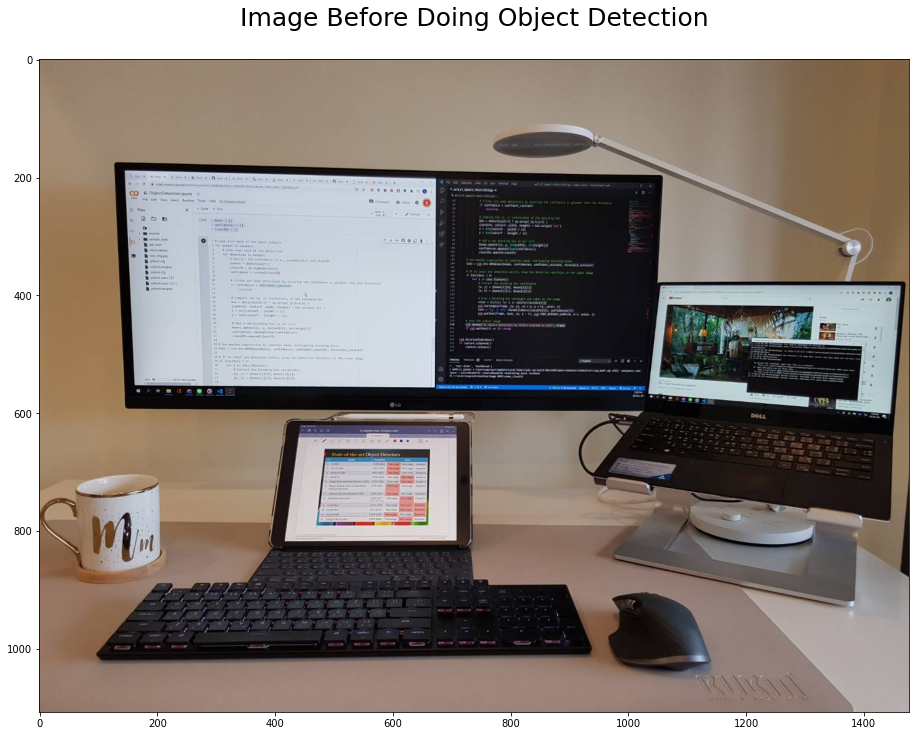

In [5]:
# Read file and display
img = cv2.imread(dir_img_test)
plt.figure(figsize=(20,12))
plt.title('Image Before Doing Object Detection\n', fontsize=25)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

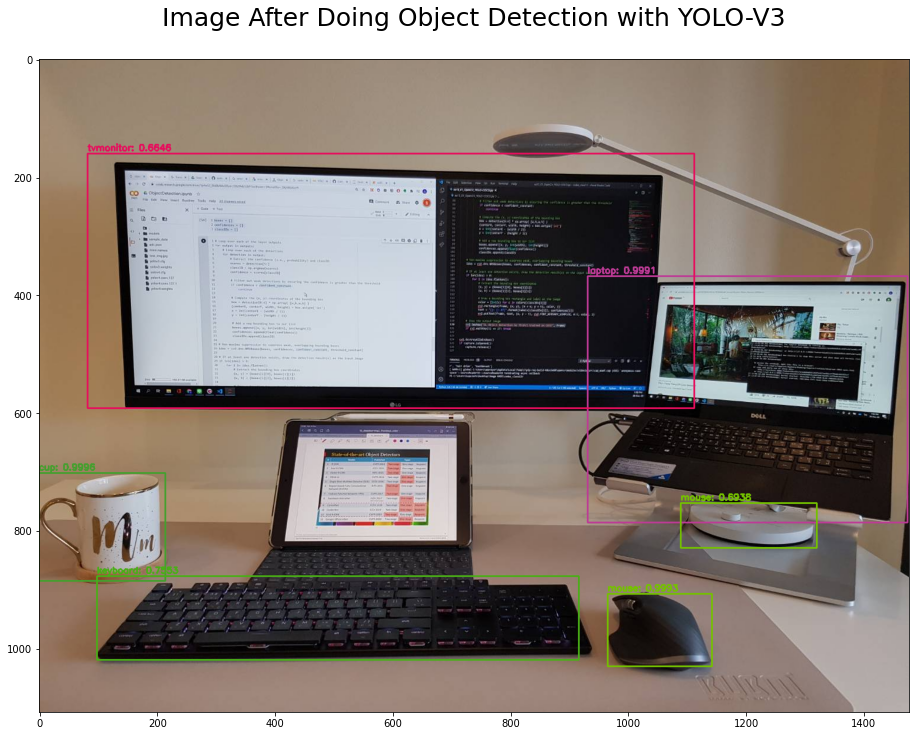

{'tvmonitor': 1, 'laptop': 2, 'keyboard': 1, 'cup': 4, 'mouse': 4}


In [6]:
# Be careful, each model requires different preprocessing!!!
h,w = img.shape[:2]
blob = cv2.dnn.blobFromImage(img,
                             1 / 255.0,                # scaleFactor
                             (yolo_imgW, yolo_imgH),   # spatial size of the CNN
                             swapRB=True, crop=False)
# Pass the blob to the network
net.setInput(blob)
outputs = net.forward(olayer_name)

# Lists to store detected bounding boxes, confidences and classIDs
boxes = []
confidences = []
classIDs = []
# Loop over each of the layer outputs
for output in outputs:
    # Loop over each of the detections
    for detection in output:
        # Extract the confidence (i.e., probability) and classID
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
    
        # Filter out weak detections by ensuring the confidence is greater than the threshold
        if confidence < confident_constant:
            continue

        # Compute the (x, y)-coordinates of the bounding box
        box = detection[0:4] * np.array( [w,h,w,h] )
        (centerX, centerY, width, height) = box.astype('int')
        x = int(centerX - (width / 2))
        y = int(centerY - (height / 2))

        # Add a new bounding box to our list
        boxes.append([x, y, int(width), int(height)])
        confidences.append(float(confidence))
        classIDs.append(classID)

# Non-maxima suppression to suppress weak, overlapping bounding boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, confident_constant, threshold_constant)

# If at least one detection exists, draw the detection result(s) on the input image
if len(idxs) > 0:
    for i in idxs.flatten():
        # Extract the bounding box coordinates
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        # Draw a bounding box rectangle and label on the image
        color = [int(c) for c in colors[classIDs[i]]]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
        cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Display image after detected
plt.figure(figsize=(20,12))
plt.title('Image After Doing Object Detection with YOLO-V3\n', fontsize=25)
plt.imshow( cv2.cvtColor( img, cv2.COLOR_BGR2RGB) )
plt.show()

# Count Detected Object
labels_map = [labels[i] for i in classIDs]
object_dic = {}
for l in labels_map:
  if l in object_dic:
    object_dic[l] +=1
  else:
    object_dic[l] = 1
print(object_dic)